## Bounding box area versus corners
Using OpenCV to do image processing and get the area of the bounding box. 

In [73]:
images = {}

In [74]:
for zscore in range(13):
    images[zscore] = {}
    
    types = ["LC", "PS"]
    for method in types: 
        for num in range(15):
            name = method + str(num)
            
            images[zscore][name] = []

**corners, bounding box, ratio box to area**

In [8]:
%matplotlib inline
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import math
from __future__ import division

In [9]:
def get_boundingBox(image_path, area=False, rotate=True):
    # get the image
    im_in = cv2.imread(image_path,0)

    # Threshold.
    # Set values equal to or above 220 to 0.
    # Set values below 220 to 255.

    th, im_th = cv2.threshold(im_in, 225, 255, cv2.THRESH_BINARY_INV);

    # Copy the thresholded image.
    im_floodfill = im_th.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv

    im_out, contours,hierarchy = cv2.findContours(im_out, 1, 2)
    cnt = contours[0]
    cntArea = cv2.contourArea(cnt)
    
    if rotate:
        # Now get the bounding box
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        if area:
            return rect[1][0] * rect[1][1], int(cntArea)

        return im_out, box
   
    else:
        x,y,w,h = cv2.boundingRect(cnt)
        box = np.array([[x,y],[x,y+h],[x+w, y+h],[x+w,y]])
        
        if area: 
            return w*h, int(cntArea)
        
        return im_out, box
    

### Testing
Testing the bounding box function and printing it out, making sure that the box is correct

0.461674008811


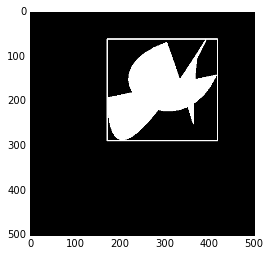

In [170]:
test_image = os.path.join(imageStimDir, str(10), "LC", "LC1103.tif")

# running function
test_box = get_boundingBox(test_image, area=False, rotate=False)

# Show the output
output = cv2.drawContours(test_box[0],[test_box[1]],0,(255,255,255),2)
plt.imshow(output, cmap = 'gray')

# Get the area
test_box = get_boundingBox(test_image, area=True, rotate=False)
print test_box[1]/test_box[0]

## Comparing all images

Now we can run on all the images, comparing the number of corners to the size of the rotated bounding box

In [217]:
cwd = os.getcwd()
imageStimDir = os.path.join(cwd, "stimuli_v1", "images")

In [248]:
corners = []
rotatedArea = []

for numCorners in range(1,14):
    LCDir = os.path.join(imageStimDir, str(numCorners), "LC")
    PSDir = os.path.join(imageStimDir, str(numCorners), "PS")
    
    for imageFile in os.listdir(LCDir):
        image_path = os.path.join(LCDir, imageFile)
        
        if imageFile == ".DS_Store":
            os.remove(image_path)
            continue
        
        area = get_boundingBox(image_path, area=True)
            
        if area[0] <= 0:
            continue
            
        corners.append(numCorners)
        rotatedArea.append(area[0])

    for imageFile in os.listdir(PSDir):
        image_path = os.path.join(PSDir, imageFile)
     
        area = get_boundingBox(image_path, area=True)
        if area[0] <= 0:
            continue
            
        corners.append(numCorners)
        rotatedArea.append(area[0])
        
    

### Plotting 
Plotting corners versus bounding box area


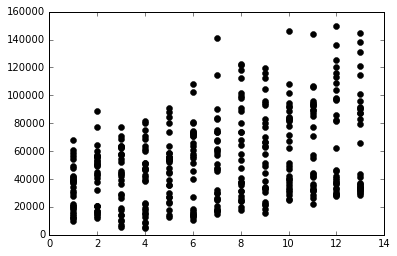

In [249]:
plt.plot(corners, rotatedArea, 'ko')

### Covariance matrix

In [250]:
rotated_data = np.array([corners, rotatedArea])

In [251]:
np.corrcoef(rotated_data)

array([[ 1.        ,  0.36333343],
       [ 0.36333343,  1.        ]])

## Comparing with a straight bounding rectangle
The rotated rectangle might not be giving us the actual representation that we want. The rotated rectangle is giving a rougher estimate of pure area, and not bounding box. Looking at straight bounding rectangle

In [265]:
corners = []
boxArea = []

for numCorners in range(1,14):
    
    
    LCDir = os.path.join(imageStimDir, str(numCorners), "LC")
    PSDir = os.path.join(imageStimDir, str(numCorners), "PS")
    
    for imageFile in os.listdir(LCDir):
        image_path = os.path.join(LCDir, imageFile)
        
        if imageFile == ".DS_Store":
            os.remove(image_path)
            continue
        
        area = get_boundingBox(image_path, area=True)
        if area[0] <= 0:
            continue
        corners.append(numCorners)
        boxArea.append(get_boundingBox(image_path, area=True, 
                                       rotate=False)[0])

    for imageFile in os.listdir(PSDir):
        image_path = os.path.join(PSDir, imageFile)
        
        area = get_boundingBox(image_path, area=True)
        if area[0] <= 0:
            continue
        corners.append(numCorners)
        boxArea.append(get_boundingBox(image_path, area=True, 
                                      rotate=False)[0])

In [11]:
cwd = os.getcwd()

In [65]:
corners = []
boxArea = []
areaRatio = []

In [75]:
for i in range(13):
    sc_dir = os.path.join(cwd, "images", str(i))
    print i

    for method in os.listdir(sc_dir):
        image_method = os.path.join(sc_dir, method)
        
        if method == ".DS_Store":
            os.remove(image_method)
            continue
            
        for num in range(15):
            imageFile = os.path.join(image_method, method + str(num))
            
            if imageFile == ".DS_Store" + str(num):
                os.remove(os.path.join(image_method, ".DS_Store"))
                continue
                
            area = get_boundingBox(imageFile, area=True, rotate=False)
            if area[0] <= 0:
                print "Bad: " + imageFile 
                
                
            images[i][method + str(num)].append(i+1)
            images[i][method + str(num)].append(area[0])
            images[i][method + str(num)].append(area[1]/area[0])
            
            corners.append(i+1)
            boxArea.append(area[0])    
            areaRatio.append(area[1]/area[0])

0
1
2
3
4
5
6
7
8
9
10
11
12


### Plotting 
Plotting corners versus bounding box area


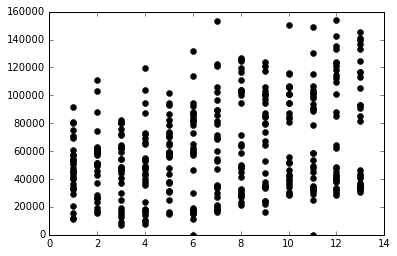

In [67]:
plt.plot(corners, boxArea, 'ko')

### Covariance matrix

In [43]:
boxData = np.array([corners, boxArea])

In [44]:
np.corrcoef(boxData)

array([[ 1.        ,  0.28159277],
       [ 0.28159277,  1.        ]])

## Bounding box:Area of shape versus corners

In [269]:
corners = []
areaRatio = []

for numCorners in range(1,14):
    
    
    LCDir = os.path.join(imageStimDir, str(numCorners), "LC")
    PSDir = os.path.join(imageStimDir, str(numCorners), "PS")
    
    for imageFile in os.listdir(LCDir):
        image_path = os.path.join(LCDir, imageFile)
        
        area = get_boundingBox(image_path, area=True, rotate=False)
        if area[0] <= 0 or area[1] <= 0:
            continue
        corners.append(numCorners+1)
        areaRatio.append(area[1]/area[0])

    for imageFile in os.listdir(PSDir):
        image_path = os.path.join(PSDir, imageFile)
        
        area = get_boundingBox(image_path, area=True, rotate=False)
        if area[0] <= 0 or area[1] <= 0:
            continue
        corners.append(numCorners+1)
        areaRatio.append(area[1]/area[0])


### Plotting 
Plotting corners versus bounding box area


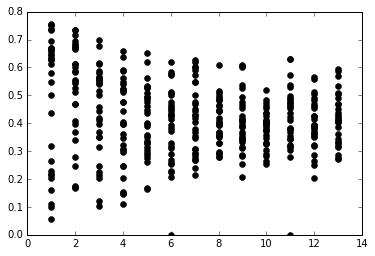

In [70]:
plt.plot(corners, areaRatio, 'ko')

### Covariance matrix

In [46]:
ratioData = np.array([corners, areaRatio])

In [47]:
np.corrcoef(ratioData)

array([[ 1.        , -0.14455407],
       [-0.14455407,  1.        ]])

# Correlations

In [71]:
allData = np.array([corners, boxArea, areaRatio])

In [72]:
np.corrcoef(allData)

array([[ 1.        ,  0.29263958, -0.1768541 ],
       [ 0.29263958,  1.        , -0.04007765],
       [-0.1768541 , -0.04007765,  1.        ]])

___

In [76]:
images

{0: {'LC0': [1, 70782, 0.10140996298493968],
  'LC1': [1, 80631, 0.16171199662660762],
  'LC10': [1, 47817, 0.22996005604701256],
  'LC11': [1, 34572, 0.21364109684137453],
  'LC12': [1, 29512, 0.31688804554079697],
  'LC13': [1, 15372, 0.62848035389019],
  'LC14': [1, 20601, 0.6618125333721664],
  'LC2': [1, 32936, 0.657639057566189],
  'LC3': [1, 11250, 0.6434666666666666],
  'LC4': [1, 74807, 0.20506102370099055],
  'LC5': [1, 54289, 0.056236069922083666],
  'LC6': [1, 12388, 0.6494995156603164],
  'LC7': [1, 57558, 0.111921887487404],
  'LC8': [1, 33184, 0.21766513982642238],
  'LC9': [1, 44802, 0.2662381143698942],
  'PS0': [1, 44660, 0.7387371249440216],
  'PS1': [1, 57043, 0.6336798555475693],
  'PS10': [1, 51106, 0.6956326067389348],
  'PS11': [1, 41006, 0.7523045407989075],
  'PS12': [1, 53934, 0.5795602032113324],
  'PS13': [1, 45864, 0.6709401709401709],
  'PS14': [1, 91745, 0.4348465856449943],
  'PS2': [1, 43044, 0.7550645850757365],
  'PS3': [1, 80330, 0.5005850865181127]

In [51]:
import json

In [77]:
imageParameters = os.path.join(os.path.dirname(cwd), "DATA", "imageParameters.json")

In [78]:
with open(imageParameters, 'w') as f:
            json.dump(images, f, sort_keys=True, indent=4)